In [2]:
print('what')

what


In [3]:
from collections import namedtuple
%matplotlib inline
import matplotlib.pyplot as plt

gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

# test the update function
predicted_pos = gaussian(10., .2**2)
measured_pos = gaussian(11., .1**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

𝒩(μ=10.800, 𝜎²=0.008)

𝒩(μ=10.000, 𝜎²=0.500)


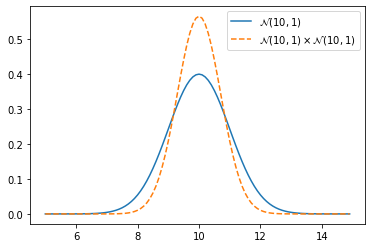

In [4]:
import filterpy.stats as stats
import numpy as np
z = gaussian(10., 1.)  # Gaussian N(10, 1)

product = gaussian_multiply(z, z)

xs = np.arange(5, 15, 0.1)
ys = [stats.gaussian(x, z.mean, z.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')

ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$', ls='--')
plt.legend()
print(product)

[1.3535959735108178, 1.8820653967131618, 4.341047429453569, 7.156332673205118, 6.938695089418526, 6.843912342028484, 9.846824080052299, 12.553482049375292, 16.2730841073834, 14.800411177015299]

In [5]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

In [6]:
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation

np.random.seed(13)

process_var = 1. # variance in the dog's movement
sensor_var = 2. # variance in the sensor

x = gaussian(0., 20.**2)  # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)]



In [7]:
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    kf_internal.print_gh(prior, x, z)

print()
print(f'final estimate:        {x.mean:10.3f}')
print(f'actual final position: {dog.x:10.3f}')

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  401.000	1.354	  1.352   1.990
  2.352    2.990	1.882	  2.070   1.198
  3.070    2.198	4.341	  3.736   1.047
  4.736    2.047	7.156	  5.960   1.012
  6.960    2.012	6.939	  6.949   1.003
  7.949    2.003	6.844	  7.396   1.001
  8.396    2.001	9.847	  9.122   1.000
 10.122    2.000	12.553	 11.338   1.000
 12.338    2.000	16.273	 14.305   1.000
 15.305    2.000	14.800	 15.053   1.000

final estimate:            15.053
actual final position:     14.838


## different variance


In [12]:
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation

np.random.seed(13)

process_var = 40. # variance in the dog's movement
sensor_var = 2. # variance in the sensor

x = gaussian(0., 20.**2)  # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)]

print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    kf_internal.print_gh(prior, x, z)

print()
print(f'final estimate:        {x.mean:10.3f}')
print(f'actual final position: {dog.x:10.3f}')

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  440.000	-2.440	 -2.424   1.991
 -1.424   41.991	-2.148	 -2.115   1.909
 -1.115   41.909	7.473	  7.082   1.909
  8.082   41.909	17.477	 17.049   1.909
 18.049   41.909	25.133	 24.810   1.909
 25.810   41.909	20.837	 21.064   1.909
 22.064   41.909	26.837	 26.620   1.909
 27.620   41.909	34.409	 34.100   1.909
 35.100   41.909	38.807	 38.638   1.909
 39.638   41.909	40.562	 40.520   1.909

final estimate:            40.520
actual final position:     40.600


In [13]:
from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider
from ipywidgets import interact

# save output in these lists for plotting
xs, predictions = [], []

process_model = gaussian(velocity, process_var) 

# perform Kalman filter
x = gaussian(0., 20.**2)
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i])
    
    plt.xlim(-1, 10)
    plt.ylim(-50, 50)
    plt.legend(loc=2);
    plt.show()
    
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=1, description='step', max=30, min=1), Output()), _dom_classes=('widget-…

In [16]:
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation

np.random.seed(13)

process_var = 2. # variance in the dog's movement
sensor_var = 40. # variance in the sensor

x = gaussian(0., 20.**2)  # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)]

print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    kf_internal.print_gh(prior, x, z)

print()
print(f'final estimate:        {x.mean:10.3f}')
print(f'actual final position: {dog.x:10.3f}')

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  402.000	4.760	  4.420  36.380
  5.420   38.380	3.787	  4.620  19.587
  5.620   21.587	7.199	  6.173  14.020
  7.173   16.020	12.188	  8.608  11.439
  9.608   13.439	3.221	  8.001  10.059
  9.001   12.059	1.738	  7.319   9.266
  8.319   11.266	9.974	  8.682   8.790
  9.682   10.790	15.812	 10.985   8.498
 11.985   10.498	28.585	 15.436   8.315
 16.436   10.315	16.673	 16.484   8.201

final estimate:            16.484
actual final position:     16.842


In [17]:
from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider
from ipywidgets import interact

# save output in these lists for plotting
xs, predictions = [], []

process_model = gaussian(velocity, process_var) 

# perform Kalman filter
x = gaussian(0., 20.**2)
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i])
    
    plt.xlim(-1, 10)
    plt.ylim(-50, 50)
    plt.legend(loc=2);
    plt.show()
    
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=1, description='step', max=30, min=1), Output()), _dom_classes=('widget-…

# Kalman Filter

## frequent seen variable names
Variance:
* P -> Prior
* Q -> Increment 
* R -> Measurement

x = x + P / (P + R) * (z - x)

$$\begin{aligned}
x = x +\frac P {P+R} * (z-x)
\end{aligned}

  


In [19]:

# posterior = gaussian(post_mean, post_var)
# prior     = gaussian(prio_mean, prio_var)

def kf_predict(posterior, movement):
    x,  P = posterior
    dx, Q = movement
    x = x + dx
    P = P + Q
    return gaussian(x, dx)

def kf_update(prior, measurement):
    x, P = prior
    z, R = measurement
    
    #residual
    y = z - x
    
    K = P / (P + R)
    
    x = x + K * y
    

    